In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
 

In [2]:
#This notebook is for analysis on the cBioPortal clinical data
#The goal is to get an idea of how to find related attributes between different studies

#load in packages
import seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import Levenshtein
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams.update({'font.size':20})

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
#load the data
file_list = np.loadtxt("data_clinical_files.txt", dtype=str)
study_names = np.asarray([i.split('/', 3)[-2] for i in file_list])

df_list = []
n_attributes = []
i=0
study_data = []
for clinical_file in file_list:
    #load in individual data from files and append to a list
    df = pd.read_table(clinical_file, skiprows=5)
    df['Study index'] = pd.Series([i]*df.shape[0], index=df.index)
    n_attributes.append(df.shape[1])
    df_list.append(df)
    study_name = clinical_file.split('/', 3)[-2]
    col_names = list(df)
    study_data.append((study_name, col_names))
    i+=1
    #break

#combine individual dataframes into a single list
all_data = pd.concat(df_list, ignore_index=True)

In [4]:
study_names_data = []
for i in study_data[0:len(study_data)]:
    for j in i[1]:
        study_names_data.append((i[0],j))

study_data_df = pd.DataFrame.from_records(study_names_data, columns = ['study name','col name'])
study_data_df2 = pd.get_dummies(study_data_df['col name'])
study_data_combined = pd.concat([study_data_df['study name'], study_data_df2], axis=1)
study_data_combined = study_data_combined.groupby('study name').sum()
study_data_combined.drop([col for col, val in study_data_combined.sum().iteritems() if val < 5], axis=1, inplace=True)

In [5]:
#plt.matshow(study_data_combined.values.T>0, cmap="RdYlGn")
#plt.xlabel('Attribute index')
#plt.ylabel('Study index')
#ax.set_xticks(np.arange(0,df3.shape[0],1))

#Which attributes are present in individual studies?

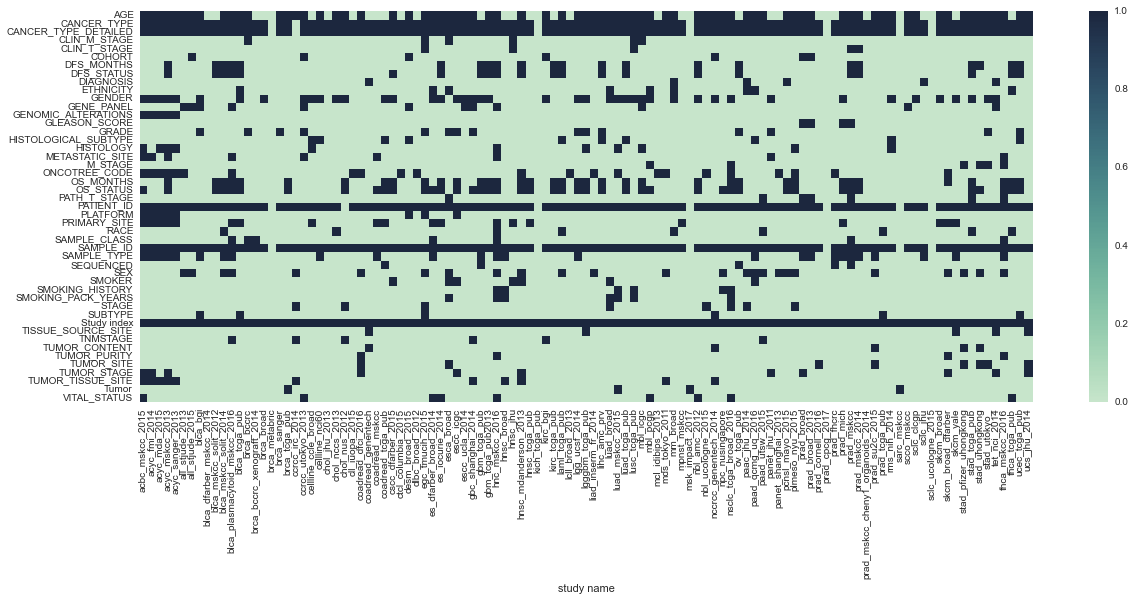

In [6]:
plt.figure(figsize=(20, 7))
cmap=seaborn.cubehelix_palette(rot=-.4, as_cmap=True)
seaborn.heatmap(study_data_combined.T>0, cmap=cmap)

#Clustering analysis based on attributes present in each study

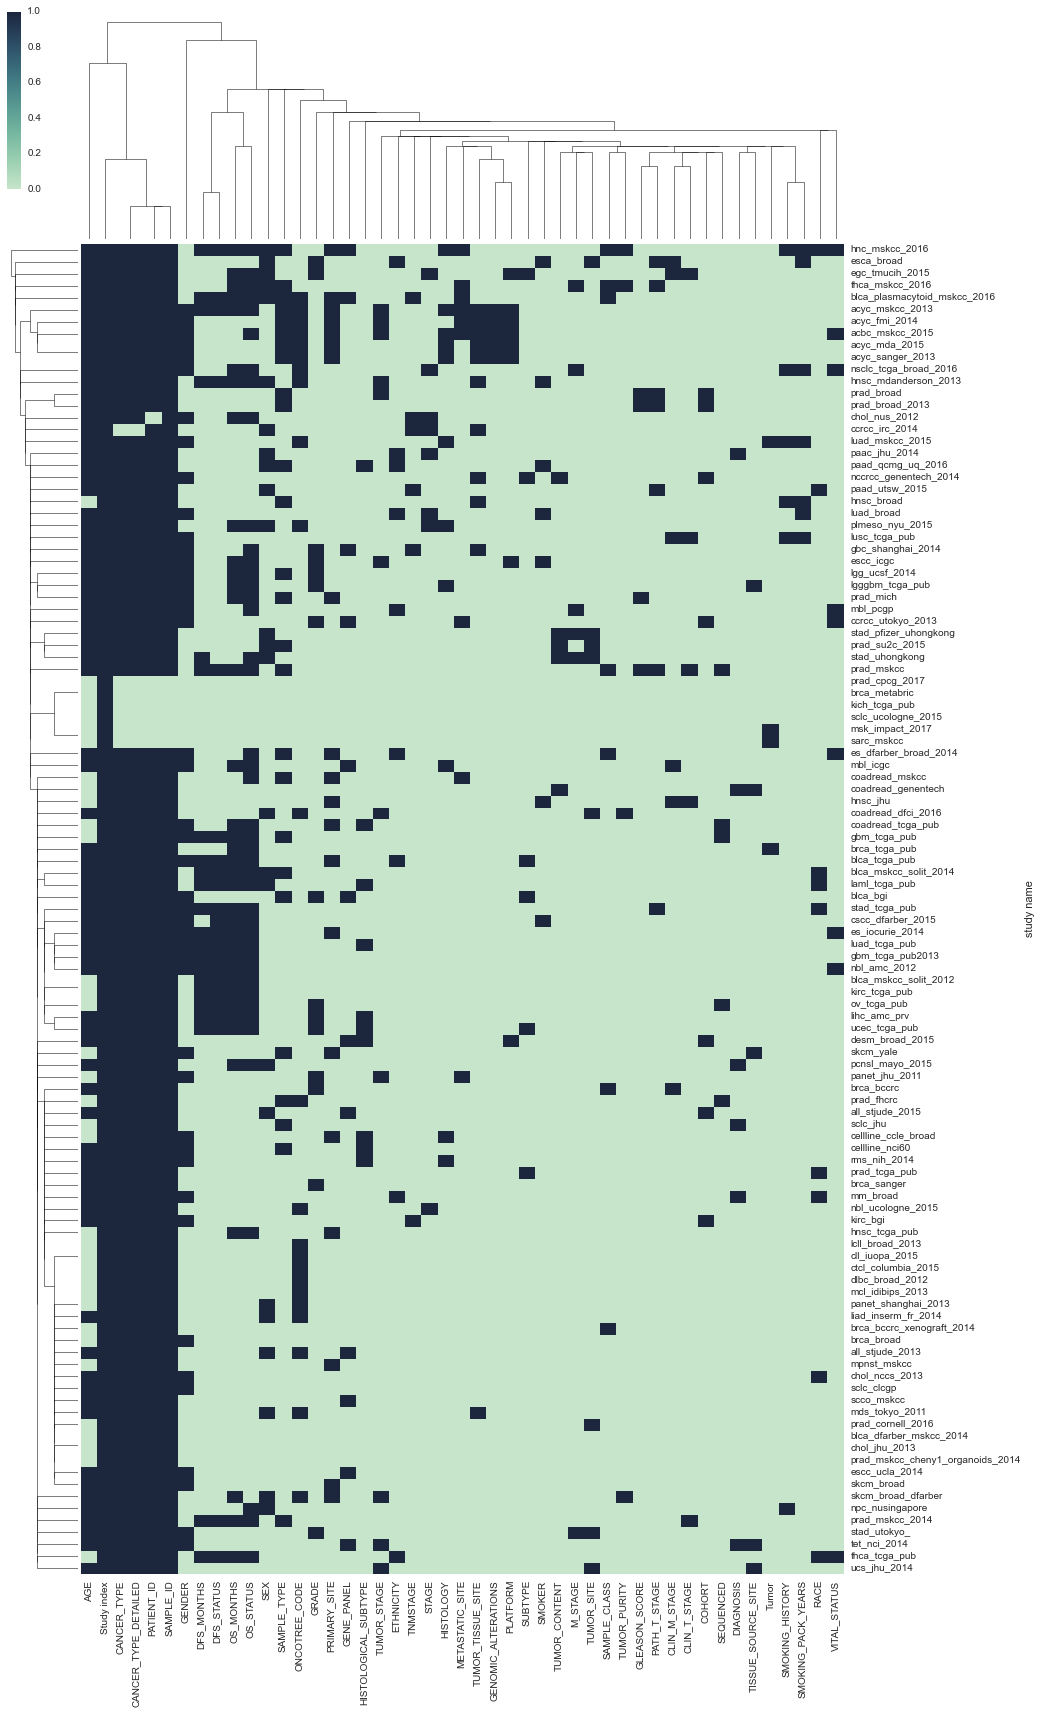

In [7]:
import seaborn
cmap=seaborn.cubehelix_palette(rot=-.4, as_cmap=True)
seaborn.clustermap(study_data_combined>0, method='single', metric = 'euclidean', figsize=(15, 28), cmap=cmap)

##It would be helpful to quantify the similarity between the names of the attributes.  The Levenshtein ratio is one way to quantify the similarity between two strings

In [8]:
#calculate the Levenshtein ratio for all pairs
all_col_names = list(all_data)
total_attributes = len(all_col_names)
lev_dist = np.zeros([total_attributes, total_attributes])
for i in range(total_attributes):
    for j in range(total_attributes):
        lev_dist[i,j]=Levenshtein.ratio(all_col_names[i].lower(), all_col_names[j].lower())

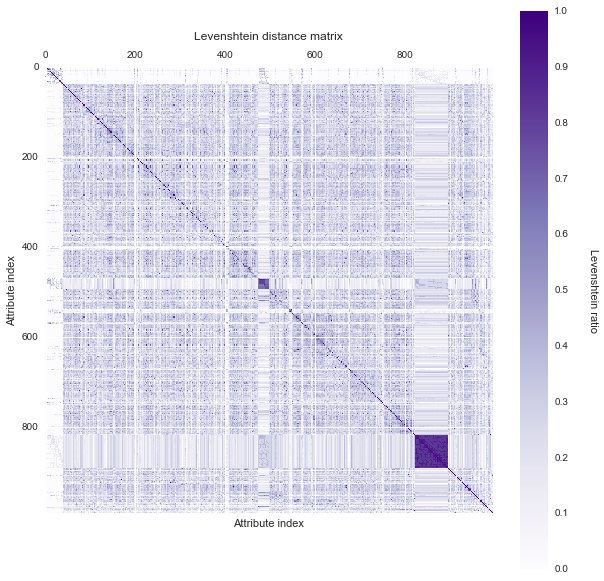

In [9]:
#Let's visualzie the Levenshtein ratio for all possible pairs
plt.rcParams['figure.figsize'] = (10, 10)
plt.matshow(lev_dist, cmap='Purples')
plt.title('Levenshtein distance matrix')
plt.ylabel('Attribute index')
plt.xlabel('Attribute index')
cbar = plt.colorbar()
cbar.set_label("Levenshtein ratio", rotation = 270, labelpad = 30)

#pairs of attributes with a Levenshtein ratio above 0.80

In [18]:
#let's take a look at the variables that have a Levenshtein ratio of > 0.80
cutoff=0.80
attribute1 = np.where((lev_dist > cutoff))[0]
attribute2 = np.where((lev_dist > cutoff))[1]

#Now let's add an additional filter to make sure the attributes come from different studies
#(this filer is helpful beacuse the same study wouldn't include the same attribute with different names)
for a1, a2 in zip(attribute1,attribute2):
    if sum(all_data[all_col_names[a1]].notnull() & all_data[all_col_names[a2]].notnull()) == 0:
        print all_col_names[a1], all_col_names[a2]

AGE Age
ALIVE alive
ARID1A_MUTATION IDH1_MUTATION
AR_SCORE ERK_score
ASSOCIATED_GENETIC_METABOLIC_DISEASE ASSOCIATED_GENETIC_METABOLIC_DISEASE
ATRX_STATUS STR_STATUS
Age AGE
Arm_SCNA_Cluster SCNA_CLUSTER
BCR_STATUS BRAF_STATUS
BCR_STATUS ER_STATUS
BCR_STATUS ER_Status
BCR_STATUS PR_STATUS
BCR_STATUS PR_Status
BIOPSY_GLEASON_SCORE_1 GLEASON_SCORE_1
BIOPSY_GLEASON_SCORE_2 GLEASON_SCORE_2
BRAF_MUTATION KRAS_MUTATION
BRAF_MUTATION RHOA_MUTATION
BRAF_STATUS BCR_STATUS
BRCA1_MUTATION KRAS_MUTATION
BRCA1_MUTATION RHOA_MUTATION
BRCA2_MUTATION KRAS_MUTATION
BRCA2_MUTATION RHOA_MUTATION
CDH1_STATUS IDH1_STATUS
CDH1_STATUS IDH_STATUS
CLINICAL_STAGE CLINICAL_STATUS
CLINICAL_STATUS CLINICAL_STAGE
CNA_CLUSTER_K4 SCNA_CLUSTER
DAYS_TO_LAST_FOLLOWUP TIME_TO_LAST_FOLLOWUP
DFS_MONTHS PFS_MONTHS
DOUBLING_TIME DOUBLING_TIME_DAYS
DOUBLING_TIME_DAYS DOUBLING_TIME
EBV_STATUS ER_STATUS
EBV_STATUS ER_Status
EBV_STATUS ETV1_STATUS
EBV_STATUS ETV4_STATUS
EFS_STATUS ER_STATUS
EFS_STATUS ER_Status
EFS_STATUS METS_S

KeyboardInterrupt: 